# Non-linear least-squares regression


**Data**: $\{(\mathbf{x}_i,y_i)  \;\;\mathrm{ for } \;i = 1,\ldots,n\}$

**Model**: $\widehat{y} = g(\mathbf{x},\boldsymbol\theta)$ - not linear in the parameters

**Fitting the model**: Choose $\boldsymbol\theta$ to minimize sum-squared error:

$$
\widehat{\boldsymbol\theta} =\underset{\boldsymbol\theta}{\arg\min} \;\sum_{i=1}^{n}\left[y_i - g(\mathbf{x}_i,\boldsymbol\theta) \right]^2
$$


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Magic command Needed for showing plots in jupyter notebooks
%matplotlib inline

In [2]:
# Adjust plot dpi and other graphical parameters
plt.rcParams.update(**{
    'figure.dpi':150,
    'figure.figsize':(4,3)
})

## Manufacturing learning curve data

y - relative efficiency of operation

Two independent variables/predictors:
    
    1. Location - 0 or 1 
    2. Week number


In [3]:
# read car data
mlc = pd.read_csv('../data/MLC.csv')
# show first five rows
mlc.head()

,Location,Week,Efficiency
0,1,1,0.483
1,1,2,0.539
2,1,3,0.618
3,1,5,0.707
4,1,7,0.762


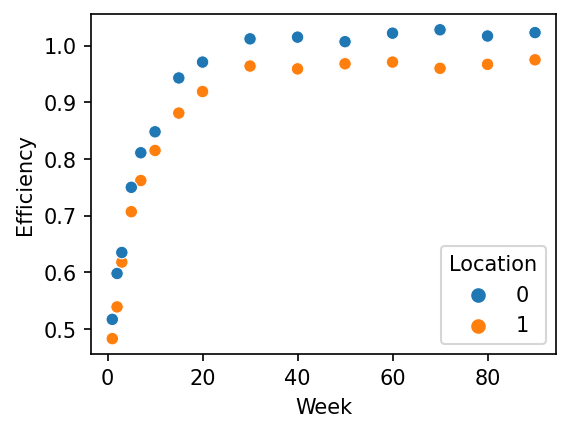

In [4]:
# Scatter plot of Efficiency vs Week for each facility
fig,ax = plt.subplots(1,1)
_ = sns.scatterplot(
    data=mlc,
    x='Week',
    y='Efficiency',
    hue='Location',
    ax=ax
)

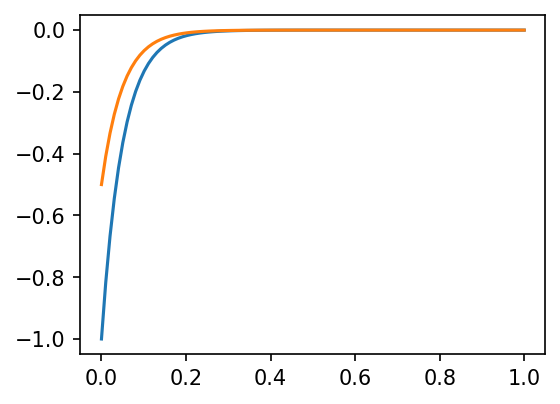

In [11]:
x = np.linspace(0,1,100)

plt.plot(x,-np.exp(-20*x))
plt.plot(x,-0.5*np.exp(-20*x))

The model we are tyring to fit is

$$
\widehat{y} = g(\mathbf{x},\theta) = \theta_0 + \theta_1x_1 + \theta_3\exp(\theta_2x_2)
$$

where $x_1$ is the location and $x_2$ is the Week #

In [12]:
def lc_model(x,theta):
    '''
    Function which returns the model:
        \widehat{y} = \theta_0 + \theta_1*Location + \theta_3\exp{\theta_2*Week}
    
    first column of x is Location
    second column of x is Week
    '''
    return theta[0]+theta[1]*x[:,0]+theta[3]*np.exp(theta[2]*x[:,1])

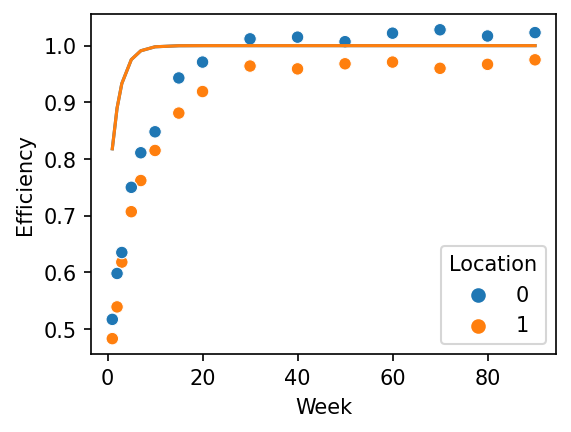

In [13]:
# fit with initial parameter guess
theta0 = np.array([1,0,-.5,-.3])

yhat_0 = lc_model(mlc[['Location','Week']].values,theta0)

# Visualize the initial curve fit 
_ = sns.lineplot(
    data = mlc,
    x = 'Week',
    y = yhat_0,
    hue = 'Location',
    ax=ax,
    legend=False
)
fig

**Question**: Why do we see only one line in the figure?



## General non-linear optimization


We will be using the `minimize` function from `scipy.optimize` for optimization of a function f over continuous variables. 

**Differences from R's `nlm`** : `minimize` supports a variety of optimization problems - `nlm` supports only unconstrained problems


In [14]:
from scipy.optimize import minimize
print(minimize.__doc__)

Minimization of scalar function of one or more variables.

    Parameters
    ----------
    fun : callable
        The objective function to be minimized.

            ``fun(x, *args) -> float``

        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of

            - 'Nelder-Mead' :ref:`(see here) <optimize.minimize-neldermead>`
            - 'Powell'      :ref:`(see here) <optimize.minimize-powell>`
            - 'CG'          :ref:`(see here) <optimize.minimize-cg>`
            - 'BFGS'        :ref:`(see here) <optimiz

In [21]:
def sum_squared_error(theta,x,y):
    '''
    Function to be minimized wrt theta
    '''
    y_hat =  lc_model(x,theta)
    return np.sum((y-y_hat)**2)


def sum_abs_error(theta,x,y):
    '''
    Function to be minimized wrt theta
    '''
    y_hat =  lc_model(x,theta)
    return np.sum(np.abs(y-y_hat))


res_nlm = minimize(
    fun=sum_abs_error, # loss function
    x0 = np.array([1,0,-.5,-.3]), # initial guess
    args=(mlc[['Location','Week']].values,mlc['Efficiency'].values), # (x,y) args to sum_squared_error
    #options = {'disp':True},
)

# Optimization object
print(res_nlm)

      fun: 0.2510489468469467
 hess_inv: array([[ 0.00068952, -0.00083444, -0.00011503, -0.00212393],
       [-0.00083444,  0.00594452,  0.00219008,  0.01136644],
       [-0.00011503,  0.00219008,  0.00127354,  0.00528102],
       [-0.00212393,  0.01136644,  0.00528102,  0.02779466]])
      jac: array([ 1.8281406 ,  0.8281406 , -0.49655976,  0.67961327])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 846
      nit: 14
     njev: 139
   status: 2
  success: False
        x: array([ 1.02096757, -0.05344513, -0.13129483, -0.55250284])


In [16]:
# Extract parameters
theta_nlm = res_nlm.x
theta_nlm

array([ 1.01559846, -0.04726681, -0.13479542, -0.55244245])

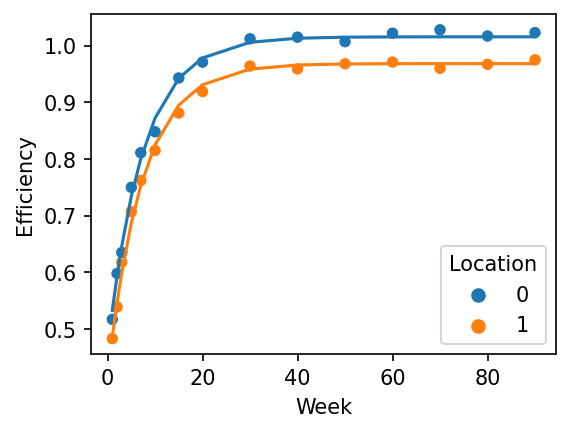

In [22]:
# visualize the fit
fig,ax = plt.subplots(1,1,figsize=(4,3))
_ = sns.scatterplot(
    data=mlc,
    x='Week',
    y='Efficiency',
    hue='Location',
    ax=ax
)

# compute model predictions with the optimized parameters
yhat = lc_model(mlc[['Location','Week']].values,theta_nlm)

# Visualize the curve fit 
_ = sns.lineplot(
    data = mlc,
    x = 'Week',
    y = yhat,
    hue = 'Location',
    ax=ax,
    legend=False
)

## Least-squares minimization

The equivalent of R's `nls` function is `curve_fit` from scipy.optimize. The functions returns the estimated parameters along with their covariance matrix.

In [18]:
from scipy.optimize import curve_fit
print(curve_fit.__doc__)


    Use non-linear least squares to fit a function, f, to data.

    Assumes ``ydata = f(xdata, *params) + eps``

    Parameters
    ----------
    f : callable
        The model function, f(x, ...).  It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : array_like or object
        The independent variable where the data is measured.
        Should usually be an M-length sequence or an (k,M)-shaped array for
        functions with k predictors, but can actually be any object.
    ydata : array_like
        The dependent data, a length M array - nominally ``f(xdata, ...)``.
    p0 : array_like, optional
        Initial guess for the parameters (length N).  If None, then the
        initial values will all be 1 (if the number of parameters for the
        function can be determined using introspection, otherwise a
        ValueError is raised).
    sigma : None or M-length sequence or MxM array

In [19]:
def lc_model_nls(x,theta_0,theta_1,theta_2,theta_3):
    '''
    Returns the model predictions for a given parameter set
    '''
    return  theta_0+theta_1*x[:,0]+theta_3*np.exp(theta_2*x[:,1])

theta_nls,cov_theta_nls = curve_fit(
    f = lc_model_nls, # the model to be fit to data 
    xdata = mlc[['Location','Week']].values,
    ydata = mlc['Efficiency'].values,
    p0 = np.array([1,0,-.5,-.3]) # initial guess
)

print('Parameter estimate:')
print(theta_nls)

print('\n Covariance estimate:')
print(cov_theta_nls)


Parameter estimate:
[ 1.01559838 -0.04726667 -0.13479537 -0.55244232]

 Covariance estimate:
[[ 1.34815643e-05 -8.44277711e-06  6.58332639e-06 -4.31887204e-06]
 [-8.44277711e-06  1.68855559e-05  4.31586498e-14 -1.63150348e-14]
 [ 6.58332639e-06  4.31586519e-14  1.90052074e-05  1.99261991e-05]
 [-4.31887204e-06 -1.63150313e-14  1.99261991e-05  6.65408132e-05]]


In [20]:
# a more convenient function

def lcmodel_nls(x,*theta):
    '''
    Returns the model predictions for a given parameter set
    '''
    return lc_model(x,theta)

theta_nls,cov_theta_nls = curve_fit(
    f = lc_model_nls, # the model to be fit to data 
    xdata = mlc[['Location','Week']].values,
    ydata = mlc['Efficiency'].values,
    p0 = np.array([1,0,-.5,-.3]) # initial guess
)

print('Parameter estimate:')
print(theta_nls)

Parameter estimate:
[ 1.01559838 -0.04726667 -0.13479537 -0.55244232]
